# Chapter 5 - Connecting Causality and Deep Learning

The notebook is a code companion to chapter 5 of the book [Causal AI](https://www.manning.com/books/causal-ai) by [Robert Osazuwa Ness](https://www.linkedin.com/in/osazuwa/).

<a href="https://colab.research.google.com/github/altdeep/causalML/blob/master/book/chapter%205/chapter_5_Connecting_Causality_and_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook was written in Google Colab using Python version 3.10.12. The versions of the main libraries include:
* pyro version 1.84
* torch version 2.2.1
* pandas version 2.0.3
* torchvision vserions 0.18.0+cu121




Pgmpy allows us to fit conventional Bayesian networks on a causal DAG. However, with modern deep probabilistic machine learning frameworks like pyro, we can build more nuanced and powerful causal models.  In this tutorial, we fit a variational autoencoder on a causal DAG that represents a dataset that mixes handwritten MNIST digits and typed T-MNIST images.

![TMNIST-MNIST](https://github.com/altdeep/causalML/blob/master/book/chapter%205/images/MNIST-TMNIST.png?raw=1)

In [30]:
# !pip install pyro-ppl==1.8.4
# !pip install torchvision

## Listing 5.1: Setup for GPU training

The code will run faster if we use CUDA, if it's available.

In [31]:
import torch    #A
USE_CUDA = True    #A
DEVICE_TYPE = torch.device("cuda" if USE_CUDA else "cpu")    #A
#A Use CUDA if it is available.

## Listing 5.2: Combining the data

First, we create a Dataset object that will combine our two datasets.

In [32]:
from torch.utils.data import Dataset

import numpy as np
import pandas as pd
from torchvision import transforms

class CombinedDataset(Dataset):    #A
    def __init__(self, csv_file):
        self.dataset = pd.read_csv(csv_file)
        print(self.dataset.shape)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        images = self.dataset.iloc[idx, 3:]    #B
        images = np.array(images, dtype='float32')/255.  #B
        images = images.reshape(28, 28)    #B
        transform = transforms.ToTensor()    #B
        images = transform(images)    #B
        digits = self.dataset.iloc[idx, 2]    #C
        digits = np.array([digits], dtype='int')    #C
        is_handwritten = self.dataset.iloc[idx, 1]    #D
        is_handwritten = np.array([is_handwritten], dtype='float32')    #D
        return images, digits, is_handwritten    #E

#A This class loads and processes a dataset that combines the MNIST and Typeface MNIST. The output is a torch.utils.data.Dataset object.
#B Load, normalize, and reshape the images to a 28x28 pixel.
#C Get and process the digits labels, 0-9.
#D 1 for handwritten digits (MNIST) 0 for “typed’ digits (TMNIST).
#E Return tuple of the image, the digit label, and the is_handwritten label.

## Listing 5.3: Downloading, splitting and loading the data

Next, we'll download the data and create the combined dataset.

In [33]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split

def setup_dataloaders(batch_size=64, use_cuda=USE_CUDA):    #A
    combined_dataset = CombinedDataset(
"https://raw.githubusercontent.com/altdeep/causalML/master/datasets/combined_mnist_tmnist_data.csv"
    )
    n = len(combined_dataset)    #B
    train_size = int(0.8 * n)    #B
    test_size = n - train_size    #B
    train_dataset, test_dataset = random_split(    #B
        combined_dataset,    #B
        [train_size, test_size],    #B
        generator=torch.Generator().manual_seed(42)    #B
    )    #B
    kwargs = {'num_workers': 1, 'pin_memory': use_cuda}
    train_loader = DataLoader(    #C
        train_dataset,    #C
        batch_size=batch_size,    #C
        shuffle=True,    #C
        **kwargs    #C
    )    #C
    test_loader = DataLoader(    #C
        test_dataset,    #C
        batch_size=batch_size,    #C
        shuffle=True,    #C
        **kwargs    #C
    )    #C
    return train_loader, test_loader
#A Setup data loader that loads the data and splits it into training and test sets
#B Allot 80% of the data to training data, the remaining 20% to test data.
#C Create training and test loaders.

In [34]:
train_loader, test_loader = setup_dataloaders()

(50000, 787)


column 0 is simply index of the datapoint in the dataset, column 1 is is_handwritten, column 2 is digits, columns 3: are image values

## Listing 5.4: Implement the decoder

First, we specify a decoder. The decoder maps the latent variable Z, a variable representing the value of the digit, and a binary variable representing whether the digit is handwritten.

In [36]:
from torch import nn

# This is the diffusion reverse model that predicts the conditional mean of the noise epsilon_t at any time step t given the noisy image x_t and the causal conditioning variables.
# The output is a vector of size img_dim with real values that directly denote the predicted noise that was added during the forward process - not a distribution.

class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        img_dim = 28 * 28
        digit_dim = 10
        is_handwritten_dim = 1
        t_dim = 1

        self.softplus = nn.Softplus()

        encoding_dim = img_dim + digit_dim + is_handwritten_dim + t_dim
        self.fc1 = nn.Linear(encoding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, img_dim)

    def forward(self, x_t, digit, is_handwritten, t):
        x_t = x_t.view(x_t.size(0), -1)
        t = t.unsqueeze(1).float()
        input = torch.cat([x_t, digit, is_handwritten, t], dim=1)
        hidden = self.softplus(self.fc1(input))
        eps_hat = self.fc2(hidden)
        return eps_hat

In [39]:
import pyro
import pyro.distributions as dist

In [46]:
class Diffusion(nn.Module):
    def __init__(self, T=1000, hidden_dim=400, use_cuda=USE_CUDA):
        super().__init__()
        self.use_cuda = use_cuda
        self.T = T
        self.hidden_dim = hidden_dim
        
        # 1. Setup the reverse-process network
        self.decoder = Decoder(hidden_dim)
        
        # 2. Setup fixed diffusion schedule
        self.setup_schedule()
        
        if self.use_cuda:
            self.cuda()

    def setup_schedule(self):
        """Precompute alpha-bars. Using register_buffer ensures these 
        move to the GPU automatically with the model."""
        betas = torch.linspace(1e-4, 0.02, self.T)
        alphas = 1.0 - betas
        # Registering as buffer handles device placement during .cuda() calls
        self.register_buffer('alpha_bars', torch.cumprod(alphas, dim=0))
        self.register_buffer('betas', betas)
        self.register_buffer('alphas', alphas)

    def q_sample(self, x0, t, eps):
        """The forward process: x0 -> xt. Anchor all constants to x0.device."""
        # Ensure t is an index tensor on the same device as alpha_bars
        t = t.to(self.alpha_bars.device)
        
        # Extract coefficients and ensure they are on the correct device
        sqrt_ab = self.alpha_bars[t].sqrt().unsqueeze(1).to(x0.device)
        sqrt_1_ab = (1 - self.alpha_bars[t]).sqrt().unsqueeze(1).to(x0.device)
        
        return sqrt_ab * x0 + sqrt_1_ab * eps

    def model(self, x0, data_size=1):
        pyro.module("decoder", self.decoder)
        device = x0.device # This is our 'anchor' device
        options = dict(dtype=torch.float32, device=device)
        
        # 1. Sample diffusion time (Batched)
        # Probabilities must be on the same device as the data
        batched_probs = torch.ones(data_size, self.T, **options) / self.T
        t = pyro.sample("t", dist.Categorical(batched_probs))

        # 2. Sample exogenous noise (The latent 'style' equivalent)
        # Using zeros_like(x0) guarantees eps is on x0's device
        eps = pyro.sample("eps", dist.Normal(torch.zeros_like(x0), 1.0).to_event(1))
        
        # 3. Sample Causal Parents
        p_digit = torch.ones(data_size, 10, **options) / 10
        digit = pyro.sample("digit", dist.OneHotCategorical(p_digit))

        p_is_hw = torch.ones(data_size, 1, **options) / 2
        is_handwritten = pyro.sample("is_handwritten", dist.Bernoulli(p_is_hw).to_event(1))

        # 4. Forward diffusion
        x_t = self.q_sample(x0, t, eps)

        # 5. Predict noise (The Decoder handles its own device internally via pyro.module)
        eps_hat = self.decoder(x_t, digit, is_handwritten, t)

        # 6. Observation
        pyro.sample("obs_eps", dist.Normal(eps_hat, 1.0).to_event(1), obs=eps)

        return x_t, eps, digit, is_handwritten

    def training_model(self, img, digit, is_handwritten, batch_size):
        # Conditioning inherits the device of the tensors passed in
        conditioned_on_data = pyro.condition(
            self.model,
            data={"digit": digit, "is_handwritten": is_handwritten}
        )
        with pyro.plate("data", batch_size):
            return conditioned_on_data(x0=img, data_size=batch_size)

    def training_guide(self, img, digit, is_handwritten, batch_size):
        """The guide must mirror the model's device placement."""
        device = img.device
        with pyro.plate("data", batch_size):
            # Anchor probabilities to the image device
            batched_probs = torch.ones(batch_size, self.T, device=device) / self.T
            pyro.sample("t", dist.Categorical(batched_probs))
            
            # Anchor noise to the image device
            pyro.sample("eps", dist.Normal(torch.zeros_like(img), 1.0).to_event(1))

## Listing 5.10 Helper function for plotting images

The following utility functions helps us visualize progress during training.

In [47]:
def plot_image(img, title=None):    #A
    fig = plt.figure()
    plt.imshow(img.cpu(), cmap='Greys_r', interpolation='nearest')
    if title is not None:
        plt.title(title)
    plt.show()
#A Helper function for plotting an image

## Listing 5.11: Define a helper functions for reconstructing and viewing the images

These additional utility functions help us selected and reshape images, as well as generate new images.

In [48]:
import matplotlib.pyplot as plt

In [50]:
import torch.nn.functional as F

def reconstruct_img(diffusion, img, digit, is_hw, t_val=500, use_cuda=USE_CUDA):
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # 1. Prepare Inputs - Ensure all are (1, Features)
    img = img.reshape(1, -1).to(device) 
    
    # Create digit tensor correctly
    digit_tensor = torch.zeros(1, 10, device=device)
    digit_tensor[0, digit] = 1.0
    
    # Create is_hw tensor as (1, 1)
    is_hw_tensor = torch.tensor([[float(is_hw)]], device=device)
    
    # Create t_tensor as (1,)
    t_tensor = torch.tensor([t_val], device=device)

    # 2. Add Noise
    eps = torch.randn_like(img)
    x_t = diffusion.q_sample(img, t_tensor, eps)

    # 3. Predict the Noise
    eps_hat = diffusion.decoder(x_t, digit_tensor, is_hw_tensor, t_tensor)

    # 4. Mathematical Reconstruction
    # Anchor alpha_bars to the correct device
    alpha_bar_t = diffusion.alpha_bars[t_tensor].to(device)
    sqrt_alpha_bar = alpha_bar_t.sqrt().unsqueeze(1)
    sqrt_one_minus_alpha_bar = (1 - alpha_bar_t).sqrt().unsqueeze(1)
    
    img_reconstructed = (x_t - sqrt_one_minus_alpha_bar * eps_hat) / sqrt_alpha_bar

    return img_reconstructed.view(28, 28).detach()

def compare_images(original, reconstruction):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    images = [original, reconstruction]
    titles = ['Original', 'Reconstructed']
    
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img.cpu(), cmap='Greys_r', interpolation='nearest')
        ax.set_title(title)
        ax.axis('off')
        
    plt.show()

## Listing 5.12: Data processing helper functions for training

Next, we'll create some helper functions for handling the data. We'll use `get_random_example` to grab random images from the dataset. `reshape_data` will convert an image and its labels into input for the encoder. We'll use `generate_data` and `generate_coded_data` will simulate an image from the model.

In [52]:
import torch.nn.functional as F

def get_random_example(loader):    #A
    random_idx = np.random.randint(0, len(loader.dataset))    #A
    img, digit, is_handwritten = loader.dataset[random_idx]    #A
    return img.squeeze(), digit, is_handwritten    #A

def reshape_data(img, digit, is_handwritten):    #B
    digit = F.one_hot(digit, 10).squeeze()    #B
    img = img.reshape(-1, 28*28)    #B
    return img, digit, is_handwritten    #B

@torch.no_grad()
def p_sample(diffusion, x_t, t, digit, is_hw):
    """
    Reverse diffusion step: samples x_{t-1} given x_t.
    """
    # 1. Predict the noise using the decoder
    eps_hat = diffusion.decoder(x_t, digit, is_hw, t)

    # 2. Calculate coefficients for the reverse step
    # Based on the DDPM math: x_{t-1} = 1/sqrt(alpha) * (x_t - beta/sqrt(1-ab) * eps_hat)
    beta_t = diffusion.betas[t]
    sqrt_one_minus_alpha_bar_t = (1 - diffusion.alpha_bars[t]).sqrt()
    sqrt_alpha_t = diffusion.alphas[t].sqrt()

    # The predicted mean of x_{t-1}
    mean = (1 / sqrt_alpha_t) * (x_t - (beta_t / sqrt_one_minus_alpha_bar_t) * eps_hat)

    if t == 0:
        return mean
    else:
        # Add a bit of 'fresh' noise (Langevin dynamics) to keep generation diverse
        noise = torch.randn_like(x_t)
        sigma_t = beta_t.sqrt() # Standard DDPM variance choice
        return mean + sigma_t * noise
    
def generate_coded_data(diffusion, use_cuda=USE_CUDA):
    device = torch.device("cuda" if use_cuda else "cpu")
    
    # 1. Start with Pure Noise (The Diffusion 'Latent')
    img_shape = (1, 28 * 28)
    x = torch.randn(img_shape, device=device)

    # 2. Sample Causal Parents (Digit and Style)
    p_digit = torch.ones(1, 10, device=device) / 10
    digit = dist.OneHotCategorical(p_digit).sample()
    
    p_is_hw = torch.ones(1, 1, device=device) / 2
    is_handwritten = dist.Bernoulli(p_is_hw).sample()

    # 3. The Reverse Loop (The 'Generation' work)
    # We step from t=999 all the way down to t=0
    for t_idx in reversed(range(diffusion.T)):
        t_tensor = torch.tensor([t_idx], device=device)
        x = p_sample(diffusion, x, t_tensor, digit, is_handwritten)

    return x, digit, is_handwritten

def generate_data(diffusion, use_cuda=USE_CUDA):
    # This remains the wrapper that cleans up shapes for plotting
    img, digit, is_handwritten = generate_coded_data(diffusion, use_cuda)
    
    img = img.squeeze().view(28, 28).detach()
    digit = torch.argmax(digit, 1)
    # is_handwritten for Bernoulli is usually just the value
    is_handwritten = is_handwritten.squeeze().round().int() 
    
    return img, digit, is_handwritten

## Listing 5.13: Set up the training procedure

Next we set up traing. The training objective `Trace_ELBO` simultaneously trains the parameters of the encoder and the decoder. It focuses on minimizing reconstruction error (how much information is lost when an image encoded, and then decoded once again) and [KL-divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) between the distribution modeled by the guide (the variational distribution) and the P(Z|image, is_handwritten, digit).

In [54]:
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# 1. Clear previous parameters
pyro.clear_param_store()

# 2. Initialize the Diffusion Class
T_steps = 1000
diffusion_model = Diffusion(T=T_steps, hidden_dim=400)
train_loader, test_loader = setup_dataloaders(batch_size=256)

# 3. Setup Optimizer
# We use a slightly lower learning rate often preferred for Diffusion
optimizer = Adam({"lr": 1.0e-3})

# 4. Define Model and Guide
# We point SVI to the 'training' versions we wrote
model = diffusion_model.training_model
guide = diffusion_model.training_guide

# 5. Initialize SVI
# Trace_ELBO works here because our 'model' has an 'obs=' statement 
# and our 'guide' samples the same latent variables (t, eps).
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())

(50000, 787)


## Listing 5.14: Setting up a test evaluation procedure

When training generative models, it is useful to setup a procedure that uses test data to evaluate how well training is progressing. You can include anything you think is useful to monitor during training. Here, I calculate and print the loss function on the test data, just to make sure test loss is progressively decreasing along with training loss (a flattening of test loss while training loss continued to decrease would indicate overfitting).

But a more direct signal at how well our model is training is to generate and view images. In my test evaluation procedure, I produce two visualizations. First, I inspect how well it can reconstruct a random image from the test data. I pass the image through the encoder then through the decoder, creating a “reconstruction” of the image. Then I plot the original and reconstructed image side-by-side and compare them visually, looking to see that they are close to identical.

Next, I visualize how well it is performing as an overall generative model by generating and plotting an image from scratch. I run this code once each time a certain number of epochs are run.

In [56]:
def test_epoch(diffusion, test_loader, epoch):
    epoch_loss_test = 0
    
    # 1. Calculate Test Loss (Quantitative Check)
    for img, digit, is_hw in test_loader:
        batch_size = img.shape[0]
        if USE_CUDA:
            img, digit, is_hw = img.cuda(), digit.cuda(), is_hw.cuda()
            
        img, digit, is_hw = reshape_data(img, digit, is_hw)
        
        # evaluate_loss does everything step() does but WITHOUT updating weights
        epoch_loss_test += svi.evaluate_loss(img, digit, is_hw, batch_size)
        
    test_size = len(test_loader.dataset)
    avg_loss = epoch_loss_test / test_size
    print(f"Epoch: {epoch} avg. test loss: {avg_loss:.4f}")

    # 2. Visualize Reconstruction (Qualitative Check: Denoising)
    print("Comparing a random test image to its (one-step) reconstruction:")
    img_r, digit_r, is_hw_r = get_random_example(test_loader)
    
    # We use a mid-range t (e.g., 400) to see if it can recover from significant noise
    t_test = 400 
    img_recon = reconstruct_img(diffusion, img_r, digit_r, is_hw_r, t_val=t_test)
    
    # You might want to modify compare_images to show the original vs reconstruction
    compare_images(img_r.view(28, 28), img_recon)

    # 3. Generate New Image (Qualitative Check: Full Reverse Process)
    print("Generate a brand new image by sampling from pure noise:")
    # This calls your generate_data function with the 1000-step loop
    img_gen, digit_gen, is_hw_gen = generate_data(diffusion)
    
    plot_image(img_gen, f"Generated: Digit {int(digit_gen)}")
    print(f"Intended digit: {int(digit_gen)}")
    print(f"Intended as handwritten: {bool(is_hw_gen == 1)}")

## Listing 5.15: Running training and plotting progress

Finally, we run training.

Epoch: 0 | Avg Training Loss (ELBO): 1264.2377
Epoch: 0 avg. test loss: 1062.0318
Comparing a random test image to its (one-step) reconstruction:


/local/scratch/a/jshreeku/tmp/ipykernel_2809716/2670287072.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  is_hw_tensor = torch.tensor([[float(is_hw)]], device=device)


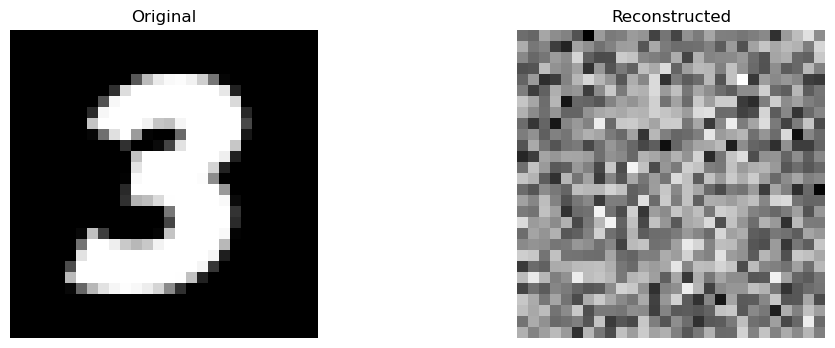

Generate a brand new image by sampling from pure noise:


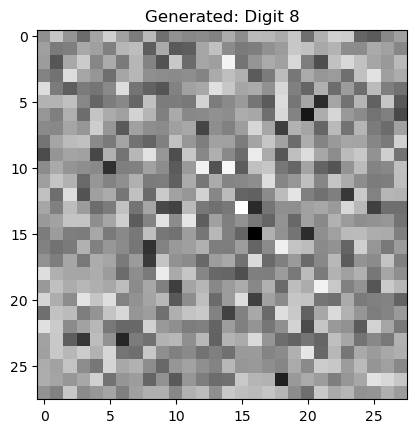

Intended digit: 8
Intended as handwritten: False
Epoch: 1 | Avg Training Loss (ELBO): 1029.5030
Epoch: 2 | Avg Training Loss (ELBO): 985.3782
Epoch: 3 | Avg Training Loss (ELBO): 968.3978
Epoch: 4 | Avg Training Loss (ELBO): 956.7189
Epoch: 5 | Avg Training Loss (ELBO): 949.6701
Epoch: 6 | Avg Training Loss (ELBO): 947.4355
Epoch: 7 | Avg Training Loss (ELBO): 945.8050
Epoch: 8 | Avg Training Loss (ELBO): 945.7127
Epoch: 9 | Avg Training Loss (ELBO): 945.8406
Epoch: 10 | Avg Training Loss (ELBO): 944.9247
Epoch: 10 avg. test loss: 950.6541
Comparing a random test image to its (one-step) reconstruction:


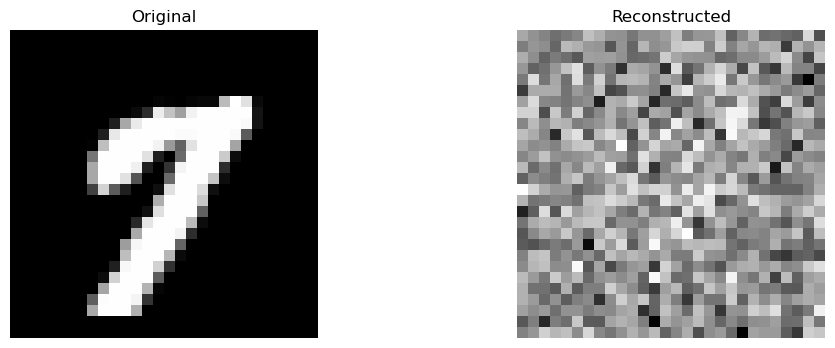

Generate a brand new image by sampling from pure noise:


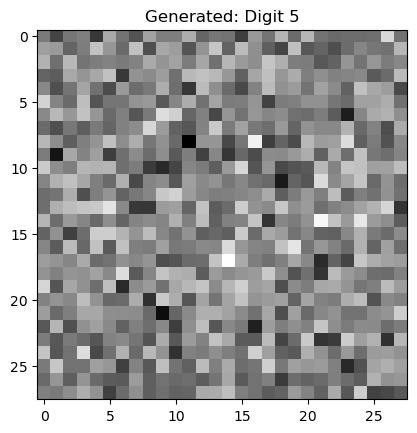

Intended digit: 5
Intended as handwritten: False
Epoch: 11 | Avg Training Loss (ELBO): 944.8477
Epoch: 12 | Avg Training Loss (ELBO): 945.0776
Epoch: 13 | Avg Training Loss (ELBO): 945.0692
Epoch: 14 | Avg Training Loss (ELBO): 944.8299
Epoch: 15 | Avg Training Loss (ELBO): 944.4469
Epoch: 16 | Avg Training Loss (ELBO): 944.5571
Epoch: 17 | Avg Training Loss (ELBO): 944.4120
Epoch: 18 | Avg Training Loss (ELBO): 944.5576
Epoch: 19 | Avg Training Loss (ELBO): 944.0549
Epoch: 20 | Avg Training Loss (ELBO): 944.3943
Epoch: 20 avg. test loss: 947.9045
Comparing a random test image to its (one-step) reconstruction:


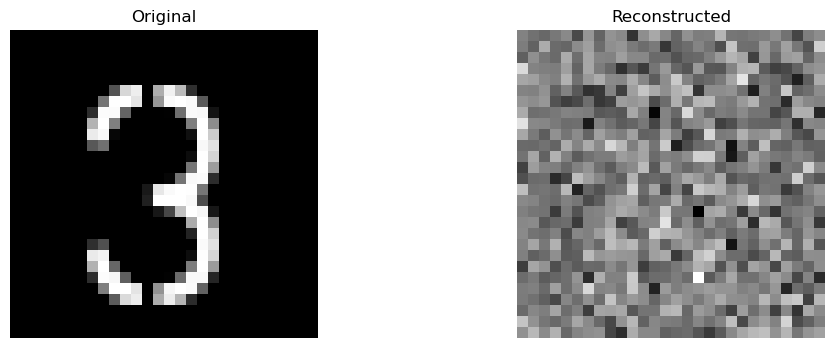

Generate a brand new image by sampling from pure noise:


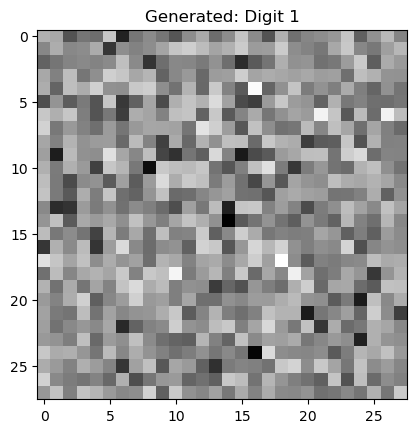

Intended digit: 1
Intended as handwritten: True
Epoch: 21 | Avg Training Loss (ELBO): 944.5392
Epoch: 22 | Avg Training Loss (ELBO): 944.0439
Epoch: 23 | Avg Training Loss (ELBO): 944.1447
Epoch: 24 | Avg Training Loss (ELBO): 944.0254
Epoch: 25 | Avg Training Loss (ELBO): 944.4094
Epoch: 26 | Avg Training Loss (ELBO): 944.4202
Epoch: 27 | Avg Training Loss (ELBO): 944.1908
Epoch: 28 | Avg Training Loss (ELBO): 944.3875
Epoch: 29 | Avg Training Loss (ELBO): 944.1422
Epoch: 30 | Avg Training Loss (ELBO): 944.3361
Epoch: 30 avg. test loss: 947.9842
Comparing a random test image to its (one-step) reconstruction:


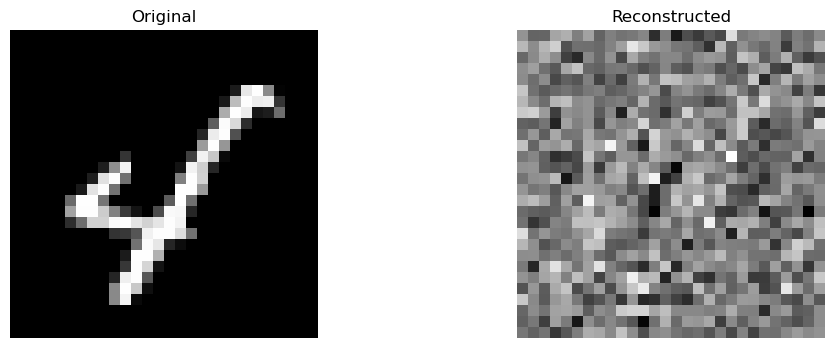

Generate a brand new image by sampling from pure noise:


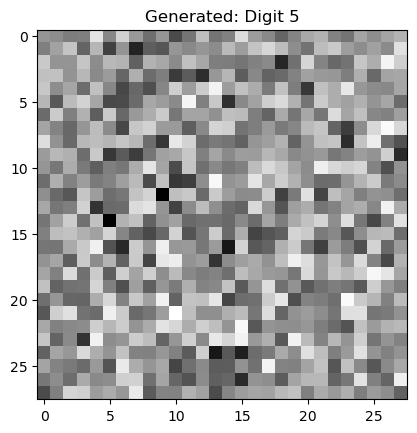

Intended digit: 5
Intended as handwritten: False
Epoch: 31 | Avg Training Loss (ELBO): 944.2465
Epoch: 32 | Avg Training Loss (ELBO): 944.4153
Epoch: 33 | Avg Training Loss (ELBO): 943.8759
Epoch: 34 | Avg Training Loss (ELBO): 943.8601
Epoch: 35 | Avg Training Loss (ELBO): 943.9470


KeyboardInterrupt: 

In [58]:
NUM_EPOCHS = 2500
TEST_FREQUENCY = 10  # Note: Generation is slow, so you might increase this later

train_loss = []
train_size = len(train_loader.dataset)

for epoch in range(0, NUM_EPOCHS + 1):
    loss = 0
    for img, digit, is_handwritten in train_loader:
        batch_size = img.shape[0]
        
        if USE_CUDA:
            img = img.cuda()
            digit = digit.cuda()
            is_handwritten = is_handwritten.cuda()
            
        # Re-use your existing reshape_data function
        img, digit, is_handwritten = reshape_data(img, digit, is_handwritten)
        
        # SVI.step logic:
        # This calls: training_model(img, digit, is_handwritten, batch_size)
        # And: training_guide(img, digit, is_handwritten, batch_size)
        loss += svi.step(img, digit, is_handwritten, batch_size)
        
    avg_loss = loss / train_size
    train_loss.append(avg_loss)
    
    print(f"Epoch: {epoch} | Avg Training Loss (ELBO): {avg_loss:.4f}")

    # Run the qualitative and quantitative test procedure
    if epoch % TEST_FREQUENCY == 0:
        # Note: We pass 'diffusion_model' (your class instance) instead of 'vae'
        test_epoch(diffusion_model, test_loader, epoch)

We can continue to use `generate_data` to generate from the model once we've trained it. Finally, we can save the resulting model.

In [ ]:
#torch.save(vae.state_dict(), 'mnist_tmnist_weights.pt')